# Predicting the Sale Price of Bulldozers

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much simila bulldozers have been sold for ?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data.

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set used for tuning hyperparameters.
* Test.csv is the test set on which predictions are to be made.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

## 3. Evaluation

The Evaluation metric is RMSLE (root mean squared log error) between the actual and predicted auction prices.

## 4. Features

Dataset features can be viewed in the Data Dictionary in the data folder. 

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import my_utils as mu

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_log_error, mean_absolute_error, r2_score

from sklearn.model_selection import validation_curve
from sklearn.model_selection import ValidationCurveDisplay


from sklearn.ensemble import RandomForestRegressor


# 2. Load Data

In [155]:
# Import training and validation datasets
df = pd.read_csv(filepath_or_buffer="data/TrainAndValid.csv", 
                 low_memory=False,
                 parse_dates=["saledate"])

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [157]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

# 3. Exploratory Data Analysis

### Numeric Features

In [158]:
num_feature_cols = ["SalePrice", "YearMade", "MachineHoursCurrentMeter", "Tire_Size"]

In [159]:
df["ModelID"].value_counts()

ModelID
4605     5348
3538     4976
3170     4364
4604     4296
3362     4186
         ... 
28498       1
2282        1
302         1
22761       1
16361       1
Name: count, Length: 5281, dtype: int64

In [160]:
num_cols = df.select_dtypes(exclude=["object", "datetime64[ns]"]).columns
num_cols

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter'],
      dtype='object')

## Sale Price Distribution

In [161]:
# Define bins and labels for price categories to be visualized
bins = [0, 20000, 50000, 100000, 150000]
labels = ["< 20k", "20k-50k", "50k-100k", "100k-150k"]

# Visualize distribution
sns.countplot(data=df,
              x=pd.cut(df["SalePrice"], bins=bins, labels=labels), # price category
              palette="viridis", 
              hue="PriceCategory")
plt.title("Distribution of Sale Price Categories")
plt.xlabel("Price Range")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(mu.format_to_dollars))
plt.show()


ValueError: Could not interpret value `PriceCategory` for `hue`. An entry with this name does not appear in `data`.

## Average Sale Price By Sale Date

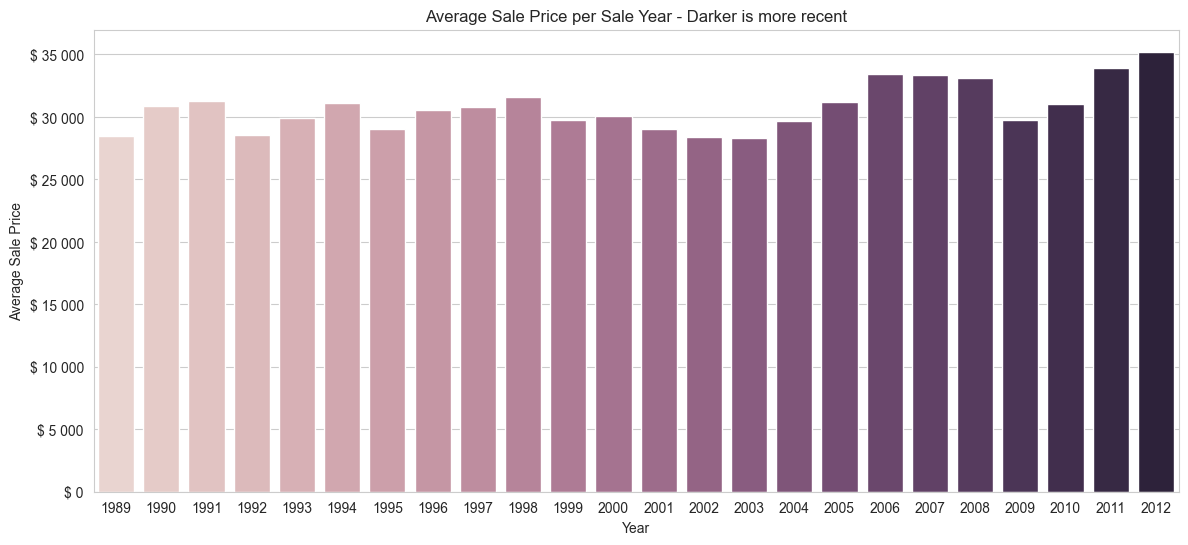

In [162]:
df_grouped_by_date = df.groupby(df['saledate'].dt.year)['SalePrice'].mean()

plt.figure(figsize=(14, 6))
sns.barplot(x=df_grouped_by_date.index, y=df_grouped_by_date.values, hue=df_grouped_by_date.index, legend=False)
plt.xlabel("Year")
plt.ylabel("Average Sale Price")
plt.title("Average Sale Price per Sale Year - Darker is more recent")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(mu.format_to_dollars))
plt.show()

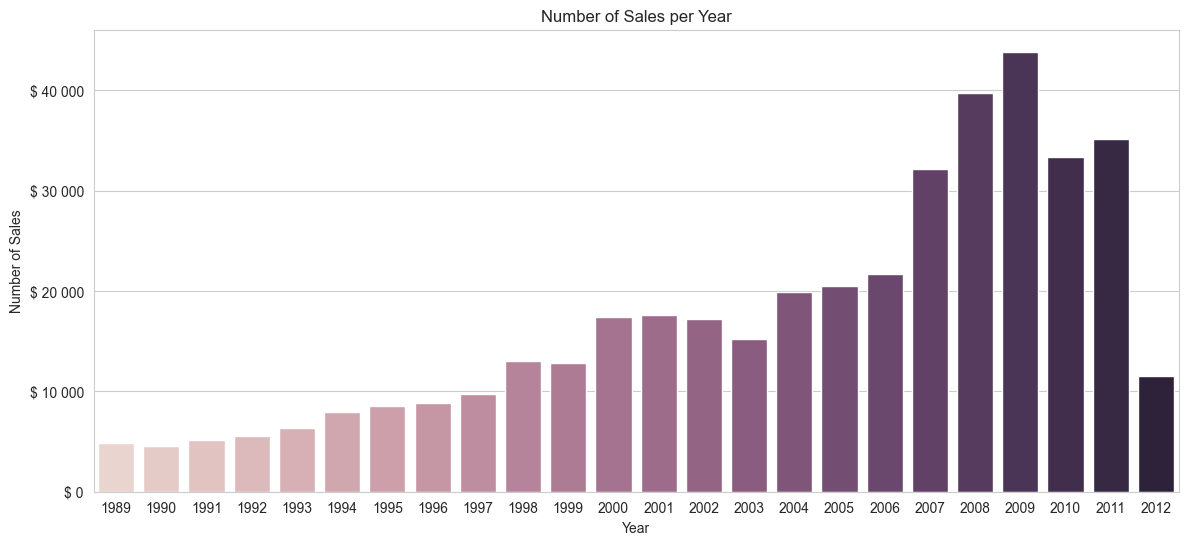

In [163]:
df_grouped_by_date = df.groupby(df['saledate'].dt.year).size()

plt.figure(figsize=(14, 6))
sns.barplot(x=df_grouped_by_date.index, y=df_grouped_by_date.values, hue=df_grouped_by_date.index, legend=False)
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.title("Number of Sales per Year")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(mu.format_to_dollars))
plt.show()

### Year Made

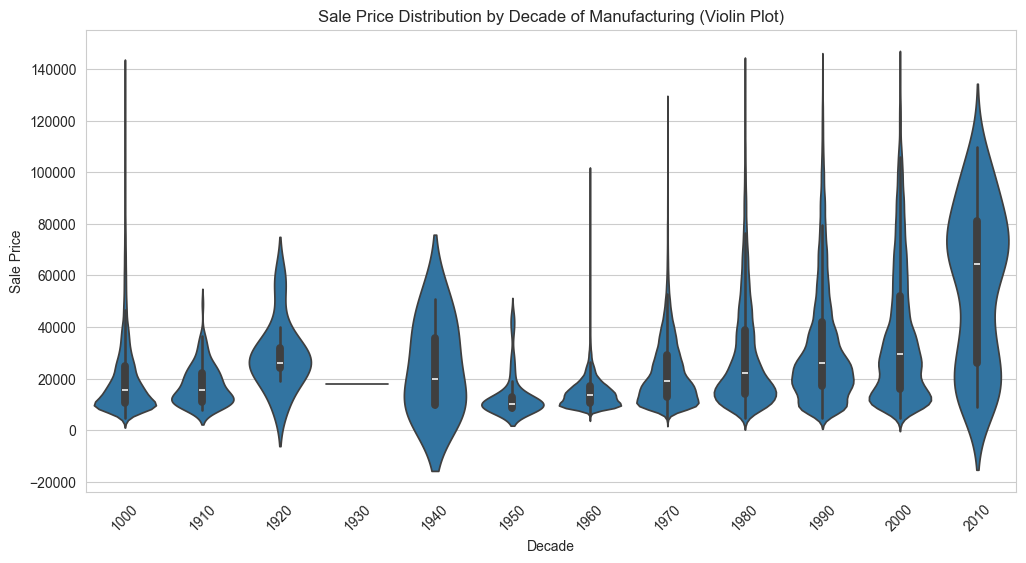

In [164]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, 
               x=(df["YearMade"] // 10) * 10,  # Group by Decade, 
                y="SalePrice", density_norm="width")
plt.title("Sale Price Distribution by Decade of Manufacturing (Violin Plot)")
plt.xlabel("Decade")
plt.ylabel("Sale Price")
plt.xticks(rotation=45)
plt.show()


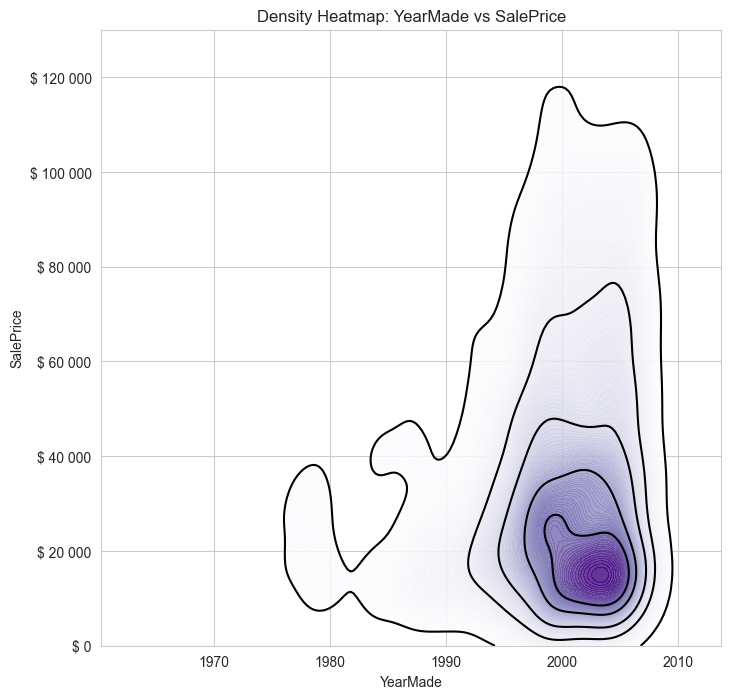

In [165]:
plt.figure(figsize=(8, 8))
sns.kdeplot(
    data=df[df["YearMade"] > 1900][:10_000],
    x="YearMade",
    y="SalePrice",
    fill=True,
    cmap="Purples",
    levels=100,
    alpha=0.8,
    clip=((df["YearMade"].min(), df["YearMade"].max()), (0, df["SalePrice"].max()))
)
sns.kdeplot(
    data=df[df["YearMade"] > 1900][:10_000],
    x="YearMade",
    y="SalePrice",
    color="black", 
    levels=6,
    clip=((df["YearMade"].min(), df["YearMade"].max()), (0, df["SalePrice"].max()))
)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(mu.format_to_dollars))
plt.ylim(0, 130_000)
plt.title("Density Heatmap: YearMade vs SalePrice")
plt.show()


In [166]:
df[df["SalePrice"] <= 0]


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls


In [167]:
below_1950_year_made = df[df["YearMade"] < 1950]
below_1950_year_made.head(100)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
9,1139275,65000.0,1016474,3883,121,3.0,1000,20700.0,Medium,2007-08-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
21,1139333,34500.0,999192,3350,121,3.0,1000,16328.0,Medium,2006-10-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,1139369,14000.0,1050658,1918,121,3.0,1000,0.0,NaN,2010-01-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
35,1139382,10000.0,1068548,112,121,3.0,1000,3981.0,Low,2011-06-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
36,1139390,8250.0,1011114,7110,121,3.0,1000,0.0,NaN,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,1141593,46000.0,19090,3357,121,3.0,1000,14205.0,Medium,2009-08-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,1141623,12500.0,720231,4200,121,3.0,1000,1701.0,Low,2007-10-25,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
734,1141630,87000.0,1005923,4149,121,3.0,1000,19368.0,Medium,2011-05-05,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Semi U,Differential Steer,NaN,NaN
736,1141649,32000.0,76817,2759,121,3.0,1000,17293.0,High,2007-05-03,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [168]:
below_1950_year_made["datasource"].value_counts()

datasource
132    21550
136    10469
121     4671
149     2468
172      384
Name: count, dtype: int64

No explanation found for why the year made of a bulldozer could be 1000 or even before 1950. We'll replace it with the median value for all samples concerned.

### Is price impacted by the auctioneer ?

In [169]:
df["auctioneerID"].value_counts().sort_index()

auctioneerID
0.0        536
1.0     192773
2.0      57441
3.0      30288
4.0      20877
5.0       7002
6.0      11950
7.0       7847
8.0       7419
9.0       4764
10.0      5876
11.0      3823
12.0      3610
13.0      3068
14.0      2277
15.0      1742
16.0      1807
17.0      1275
18.0      2359
19.0      2074
20.0      2238
21.0      1601
22.0      1429
23.0      1322
24.0      1357
25.0       959
26.0       796
27.0      1150
28.0       860
99.0     12042
Name: count, dtype: int64

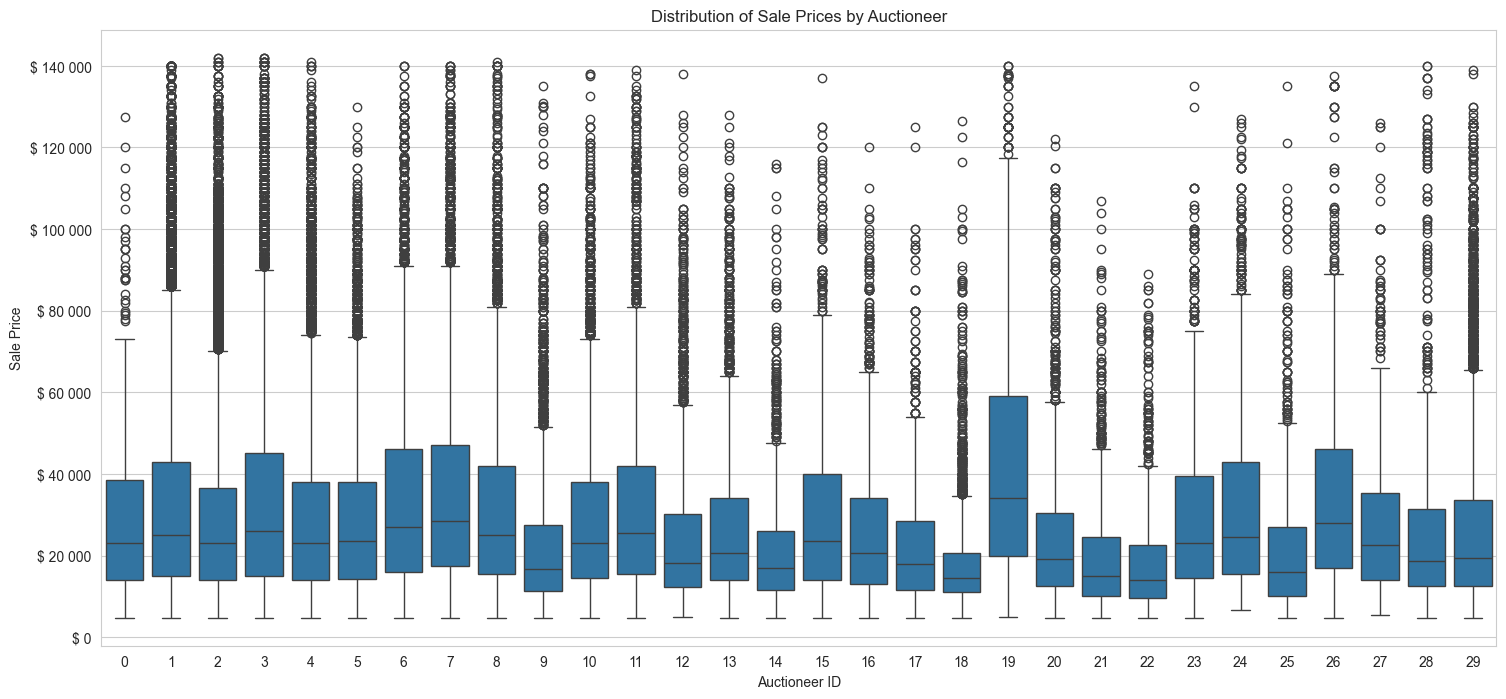

In [170]:
plt.figure(figsize=(18, 8))
sns.boxplot(data=df[["auctioneerID","SalePrice"]], x="auctioneerID", y="SalePrice")
plt.title("Distribution of Sale Prices by Auctioneer")
plt.xlabel("Auctioneer ID")
plt.ylabel("Sale Price")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(mu.format_to_dollars))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.show()


# 4. Feature Engineering

In [171]:
# Sort data by sale date
df.sort_values(by=["saledate"], inplace=True, ascending=True)

# Make a copy of the original dataframe
df_tmp = df.copy()

# Add datetime parameters for saledate column

df_tmp["SaleYear"] = df_tmp["saledate"].dt.year
df_tmp["SaleMonth"] = df_tmp["saledate"].dt.month
df_tmp["SaleDayOfWeek"] = df_tmp["saledate"].dt.day_of_week
df_tmp["SaleDayOfYear"] = df_tmp["saledate"].dt.day_of_year

# Remove saledate column as no longer needed
df_tmp.drop(columns=["saledate"], inplace=True)

In [172]:
df_tmp["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

# 5. Pre-processing

In [173]:
def get_cat_feature_names(data):
    return list(df_tmp.select_dtypes(include=["object"]))
    

In [174]:
# Check values in columns that might potentially need to be numeric
num_check_cols = [
    "Engine_Horsepower",
    "Tire_Size",
    "Undercarriage_Pad_Width",
    "Stick_Length",
    ]
df_tmp[num_check_cols].head(2000)

,Engine_Horsepower,Tire_Size,Undercarriage_Pad_Width,Stick_Length
205615,NaN,NaN,NaN,NaN
274835,NaN,None or Unspecified,NaN,NaN
141296,NaN,NaN,NaN,NaN
212552,NaN,None or Unspecified,NaN,NaN
62755,NaN,NaN,NaN,NaN
...,...,...,...,...
118116,NaN,NaN,NaN,NaN
26221,NaN,NaN,NaN,NaN
56986,NaN,NaN,None or Unspecified,None or Unspecified
274338,NaN,NaN,None or Unspecified,None or Unspecified


In [175]:
df_tmp["Engine_Horsepower"].value_counts()

Engine_Horsepower
No          24642
Variable     1341
Name: count, dtype: int64

In [176]:
df_tmp["Tire_Size"].value_counts()

Tire_Size
None or Unspecified    47823
20.5                   15773
14"                     9111
23.5                    8760
26.5                    4635
17.5                    3971
29.5                    2767
17.5"                   1815
13"                      776
20.5"                    737
15.5                     610
15.5"                    463
23.5"                    309
7.0"                      56
23.1"                     20
10"                        9
10 inch                    3
Name: count, dtype: int64

In [177]:
# Convert tire size to numeric values in inches
ts_inches = df_tmp["Tire_Size"].str.replace('"','').str.extract(r"(\d+.?\d*)").astype(float)
df_tmp["Tire_Size_in_inches"] = ts_inches
df_tmp.drop(columns=["Tire_Size"], inplace=True)

In [178]:
df_tmp["Undercarriage_Pad_Width"].value_counts()

Undercarriage_Pad_Width
None or Unspecified    82444
32 inch                 5287
28 inch                 3152
24 inch                 2998
20 inch                 2664
30 inch                 1602
36 inch                 1544
18 inch                 1439
34 inch                  540
16 inch                  481
31 inch                  191
27 inch                  144
22 inch                  135
26 inch                   98
33 inch                   94
14 inch                   51
15 inch                   33
25 inch                   17
31.5 inch                  2
Name: count, dtype: int64

In [179]:
df_tmp["Tire_Size_in_inches"]

205615     NaN
274835     NaN
141296     NaN
212552     NaN
62755      NaN
          ... 
410879     NaN
412476     NaN
411927     NaN
407124     NaN
409203    20.5
Name: Tire_Size_in_inches, Length: 412698, dtype: float64

In [180]:
# Convert Undercarriage pad width to numeric values 
upw_inches = df_tmp["Undercarriage_Pad_Width"].str.extract(r"(\d) inch").fillna(0).astype(float)
df_tmp["Undercarriage_Pad_Width_in_inches"] = upw_inches
df_tmp.drop(columns="Undercarriage_Pad_Width", inplace=True)

In [181]:
df_tmp["Stick_Length"].value_counts()

Stick_Length
None or Unspecified    81539
9' 6"                   5832
10' 6"                  3519
11' 0"                  1601
9' 10"                  1463
9' 8"                   1462
9' 7"                   1423
12' 10"                 1087
10' 2"                  1004
8' 6"                    908
8' 2"                    614
10' 10"                  414
12' 8"                   322
11' 10"                  307
8' 4"                    274
8' 10"                   104
12' 4"                   103
9' 5"                    101
15' 9"                    87
6' 3"                     51
13' 7"                    11
13' 9"                     7
14' 1"                     7
13' 10"                    7
19' 8"                     5
15' 4"                     3
7' 10"                     3
24' 3"                     2
9' 2"                      1
Name: count, dtype: int64

In [182]:
# Convert stick length to numeric column
# Extract feet and inches values using regex
feet_inches = df_tmp["Stick_Length"].str.extract(r"(\d+)' (\d+)?\"")

# Convert feet and inch units to integer values
feet = pd.to_numeric(feet_inches.iloc[:, 0], errors='coerce').fillna(0)
inches = pd.to_numeric(feet_inches.iloc[:,1], errors='coerce').fillna(0)
total_inches = feet * 12 + inches

df_tmp["Stick_Length_in_inches"] = total_inches
df_tmp.drop(columns="Stick_Length", inplace=True)

In [183]:
# Convert string values to categorical values
categorical_data = df_tmp.select_dtypes(include=["object"])
for label, content in categorical_data.items():
    df_tmp[label] = df_tmp[label].astype("category").cat.as_ordered()

## Fill missing values

### Fill numeric values

In [184]:
def get_num_cols_with_missing_values(data):
    num_cols_with_missing = []

    for label, content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                num_cols_with_missing.append(label)
                
    return num_cols_with_missing

In [185]:
num_cols_with_missing = get_num_cols_with_missing_values(df_tmp)
num_cols_with_missing

['auctioneerID', 'MachineHoursCurrentMeter', 'Tire_Size_in_inches']

In [186]:
# Fill numeric rows with median 
for col in num_cols_with_missing[0:2]:
    # Add binary column which tells us if the data was missing
    df_tmp[col+"_is_missing"] = pd.isnull(df_tmp[col])
    # Fill missing numeric values with median
    df_tmp[col] = df_tmp[col].fillna(df_tmp[col].median())

In [187]:
most_freq_tire_size = df_tmp["Tire_Size_in_inches"].mode()[0]
df_tmp["Tire_Size_in_inches_is_missing"] = pd.isnull(df_tmp["Tire_Size_in_inches"])
df_tmp["Tire_Size_in_inches"] = df_tmp["Tire_Size_in_inches"].fillna(most_freq_tire_size)

In [188]:
get_num_cols_with_missing_values(df_tmp)

[]

### Fill missing categorical values and turning categorical features into numeric values

In [189]:
# Check for columns that are not columns and are therefore categorical 
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [190]:
# Turn categorical values into numeric values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numeric values and add + 1
        # we're adding + 1 to account for the case where sample has no catégory and pandas assigns - 1
        df_tmp[label] = pd.Categorical(content).codes + 1 

In [191]:
df_tmp[df_tmp["YearMade"] < 1950].loc[:, ["SalesID", "SalePrice", "YearMade"]]

,SalesID,SalePrice,YearMade
172520,1601392,16500.0,1000
32066,1264896,13000.0,1000
241314,1746002,23000.0,1000
237737,1739008,22500.0,1000
234229,1731124,47000.0,1000
...,...,...,...
410564,6298418,15500.0,1000
411465,6310222,5000.0,1000
405777,6256957,11500.0,1000
411522,6310488,7000.0,1000


In [192]:
# Replace year made for rows where year of manufacture is before 1950 with median value based on rows after 1950
most_freq_repl_year_made = df_tmp.loc[df_tmp["YearMade"] > 1950, "YearMade"].median()
df_tmp.loc[df_tmp["YearMade"] <= 1950, "YearMade"] = most_freq_repl_year_made


## Save pre-processed data


In [193]:
# Export current tmp dataframe
df_tmp.to_csv(path_or_buf="data/train_tmp.csv",
              index=False)

In [194]:
# Import pre-processed data
df_tmp = pd.read_csv(filepath_or_buffer="data/train_tmp.csv",
                     low_memory=False)

# 6. Modelling

## 6.1 Create an evaluation function

In [195]:
def calc_scores(model, X_train, X_valid):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validation MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": root_mean_squared_log_error(y_train, train_preds),
              "Validation RMSLE": root_mean_squared_log_error(y_valid, val_preds),
              "Training R2": r2_score(y_train, train_preds),
              "Validation R2": r2_score(y_valid, val_preds)}
    return scores
    

## 6.2 Split data into training and validation data sets

In [196]:
# Splitting data into training and validation sets
df_val = df_tmp[df_tmp["SaleYear"] == 2012]
df_train = df_tmp[df_tmp["SaleYear"] != 2012]

In [197]:
# Split data into X (features) and y (target)
X_train, y_train = df_train.drop(columns=["SalePrice"]), df_train["SalePrice"]
X_valid, y_valid = df_val.drop(columns=["SalePrice"]), df_val["SalePrice"]

In [198]:
%%time

rf_reg = RandomForestRegressor(n_jobs=-1,
                               random_state=42)

# Fit the model to the training dataset
rf_reg.fit(X=X_train, y=y_train)    

CPU times: total: 18min 55s
Wall time: 1min 32s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [199]:
# Check the score
calc_scores(rf_reg, X_train=X_train, X_valid=X_valid)

{'Training MAE': np.float64(1581.0806569024624),
 'Validation MAE': np.float64(6147.056251620151),
 'Training RMSLE': np.float64(0.08448703323760234),
 'Validation RMSLE': np.float64(0.25827498114602515),
 'Training R2': 0.9875117241329829,
 'Validation R2': 0.8725269126065475}

In [200]:
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [201]:
%%time 
## Testing the model on a subset ( to tune the hyperparameters)
rf_reg = RandomForestRegressor(n_jobs=-1,
                               random_state=42,
                               max_samples=10_000)

# Fit the model
rf_reg.fit(X_train, y_train)

CPU times: total: 37.6 s
Wall time: 3.01 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [202]:
# Calculate score
calc_scores(rf_reg, X_train=X_train, X_valid=X_valid)

{'Training MAE': np.float64(5548.715873829853),
 'Validation MAE': np.float64(6954.718457616867),
 'Training RMSLE': np.float64(0.2584301819948508),
 'Validation RMSLE': np.float64(0.2852677958320845),
 'Training R2': 0.8608513905005594,
 'Validation R2': 0.8416144576182832}

In [203]:
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 10000,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Validation Curves

### Validation curve for max_depth

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 0 to 401124
Data columns (total 99 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              401125 non-null  int64  
 1   MachineID                            401125 non-null  int64  
 2   ModelID                              401125 non-null  int64  
 3   datasource                           401125 non-null  int64  
 4   auctioneerID                         380989 non-null  float64
 5   YearMade                             401125 non-null  int64  
 6   MachineHoursCurrentMeter             142765 non-null  float64
 7   UsageBand                            401125 non-null  int64  
 8   fiModelDesc                          401125 non-null  int64  
 9   fiBaseModel                          401125 non-null  int64  
 10  fiSecondaryDesc                      401125 non-null  int64  
 11  fiModelSeries     

CPU times: total: 18min 56s
Wall time: 1min 42s


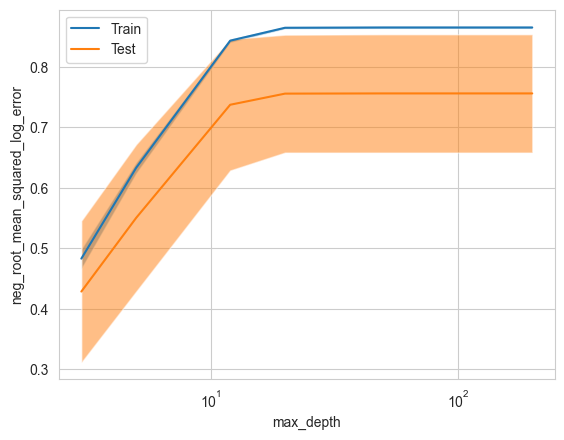

In [417]:
%%time
param_name = "max_depth"

param_range = [3, 5, 12, 20, 50, 100, 200]

ValidationCurveDisplay.from_estimator(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10_000),
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    score_name="neg_root_mean_squared_log_error"
);

CPU times: total: 31min 8s
Wall time: 2min 55s


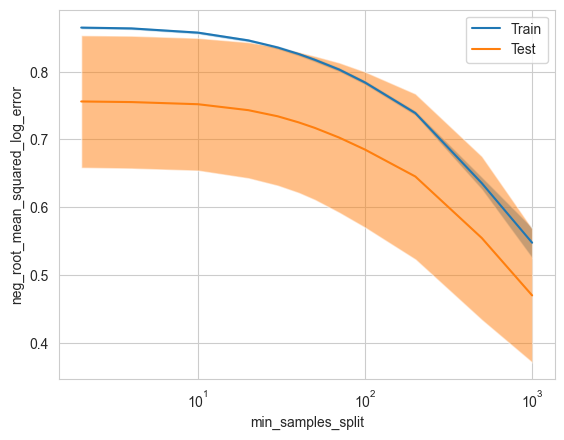

In [205]:
%%time
param_name = "min_samples_split"
param_range = [1, 2, 4, 10, 20, 30, 40, 50, 70, 100, 150, 200, 500, 1_000]

ValidationCurveDisplay.from_estimator(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10_000),
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    score_name="neg_root_mean_squared_log_error"
);

CPU times: total: 47min 4s
Wall time: 3min 59s


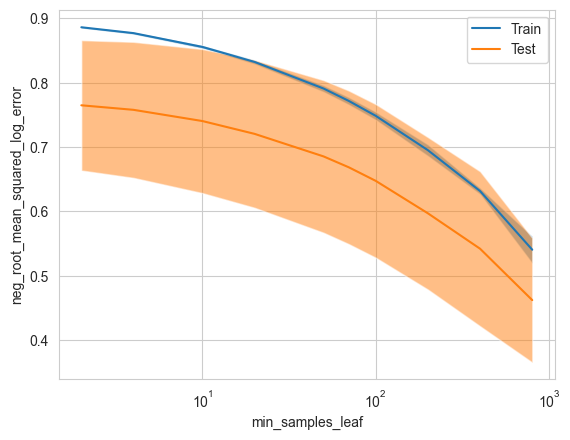

In [206]:
%%time
param_name = "min_samples_leaf"
param_range = [2, 4, 10, 20, 50, 70, 100, 200, 400, 800]

ValidationCurveDisplay.from_estimator(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=20_000),
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    score_name="neg_root_mean_squared_log_error"
);

CPU times: total: 18min 54s
Wall time: 1min 46s


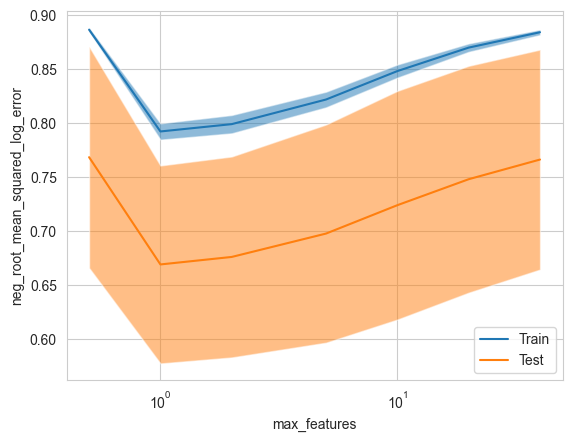

In [208]:
%%time
param_name = "max_features"
param_range = [0.5, 1, 2, 5, 10, 20, 40]

ValidationCurveDisplay.from_estimator(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=20_000),
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    score_name="neg_root_mean_squared_log_error"
);

CPU times: total: 30min 55s
Wall time: 2min 56s


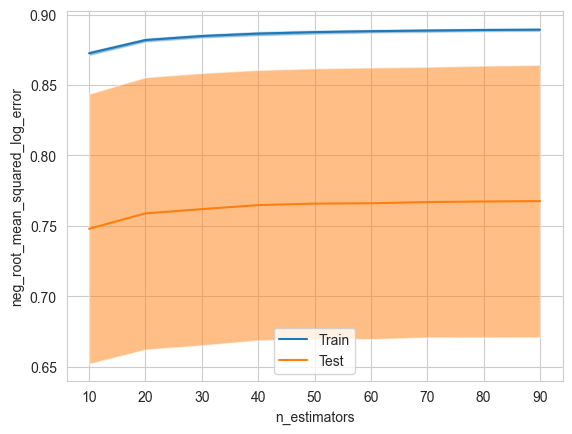

In [209]:
%%time
param_name = "n_estimators"
param_range = np.arange(10,100, 10)

ValidationCurveDisplay.from_estimator(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=20_000),
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    score_name="neg_root_mean_squared_log_error"
);

## Hyper-parameter tuning with RandomizedSearchCV

In [382]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Create parameters grid
rf_grid = {
    "n_estimators": [10, 20, 40, 50, 60],
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 10, 25, 50, 100, 150, 500],
    "min_samples_leaf": [1, 2, 10, 50, 100, 400, 500],
    "max_features": [0.5, 1, None],
    "max_samples": [10_000]
}

# Instantiate RandomizedSearchCV model
rs_rf_reg = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                               param_distributions=rf_grid,
                               n_iter=300,
                               cv=5,
                               scoring="neg_root_mean_squared_log_error",
                               verbose=True)

rs_rf_reg.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Data Science\Projects\blue_book_buldozers_time_series\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: total: 1h 25min 31s
Wall time: 13min 47s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=300,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, None],
                                        'max_samples': [10000],
                                        'min_samples_leaf': [1, 2, 10, 50, 100,
                                                             400, 500],
                                        'min_samples_split': [2, 10, 25, 50,
                                                              100, 150, 500],
                                        'n_estimators': [10, 20, 40, 50, 60]},
                   scoring='neg_root_mean_squared_log_error', verbose=True)

In [383]:
rs_rf_reg.best_params_

{'n_estimators': 60,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': None,
 'max_depth': None}

In [384]:
best_rs_rf_reg = rs_rf_reg.best_estimator_
calc_scores(model=best_rs_rf_reg,
            X_train=X_train,
            X_valid=X_valid)

{'Training MAE': np.float64(5601.216117551332),
 'Validation MAE': np.float64(7041.575347552252),
 'Training RMSLE': np.float64(0.26037022378763325),
 'Validation RMSLE': np.float64(0.2868816333037803),
 'Training R2': 0.856914140301239,
 'Validation R2': 0.8365674398098897}

In [386]:
test_rf = RandomForestRegressor(n_estimators=60,
                        min_samples_leaf=2,
                        min_samples_split=2,
                        max_features=None,
                        max_depth=None,
                        n_jobs=-1,
                        # max_samples=10_000,
                        random_state=42
                        )

test_rf.fit(X_train, y_train)
calc_scores(test_rf, X_train, X_valid)

{'Training MAE': np.float64(1975.879571110174),
 'Validation MAE': np.float64(6104.750304962082),
 'Training RMSLE': np.float64(0.10550883431251169),
 'Validation RMSLE': np.float64(0.25432108391027064),
 'Training R2': 0.9787917243972334,
 'Validation R2': 0.8738044182271405}

### Train a model with the best hyper parameters

In [387]:
%%time

best_rs_rf_reg = RandomForestRegressor(n_estimators=60,
                                       min_samples_leaf=2,
                                       min_samples_split=2,
                                       max_features=0.5,
                                       max_depth=None,
                                       n_jobs=-1,
                                       random_state=42
                                       )

best_rs_rf_reg.fit(X_train, y_train)
calc_scores(best_rs_rf_reg, X_train, X_valid)

CPU times: total: 5min 45s
Wall time: 25.4 s


{'Training MAE': np.float64(2108.0125321051937),
 'Validation MAE': np.float64(5908.644312495889),
 'Training RMSLE': np.float64(0.1102742391195757),
 'Validation RMSLE': np.float64(0.24480246607998374),
 'Training R2': 0.9770561045482297,
 'Validation R2': 0.8832013409361636}

# Make predictions on test data

In [388]:

df_test = pd.read_csv(filepath_or_buffer="data/Test.csv", 
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


## Pre-processing test data





In [390]:
def pre_process_data(data):
   

    """
    Performs transformations on data and returns the transformed data
    :param data: 
    :return: 
    """
    data["SaleYear"] = data["saledate"].dt.year
    data["SaleMonth"] = data["saledate"].dt.month
    data["SaleDayOfWeek"] = data["saledate"].dt.day_of_week
    data["SaleDayOfYear"] = data["saledate"].dt.day_of_year

    # Remove saledate column as no longer needed
    data.drop(columns=["saledate"], inplace=True)

    # Convert tire size to numeric values in inches
    ts_inches = data["Tire_Size"].str.replace('"','').str.extract(r"(\d+.?\d*)").astype(float)
    data["Tire_Size_in_inches"] = ts_inches
    data.drop(columns=["Tire_Size"], inplace=True)

    # Convert Undercarriage pad width to numeric values 
    upw_inches = data["Undercarriage_Pad_Width"].str.extract(r"(\d) inch").fillna(0).astype(float)
    data["Undercarriage_Pad_Width_in_inches"] = upw_inches
    data.drop(columns="Undercarriage_Pad_Width", inplace=True)

    # Convert stick length to numeric column
    # Extract feet and inches values using regex
    feet_inches = data["Stick_Length"].str.extract(r"(\d+)' (\d+)?\"")

    # Convert feet and inch units to integer values
    feet = pd.to_numeric(feet_inches.iloc[:, 0], errors='coerce').fillna(0)
    inches = pd.to_numeric(feet_inches.iloc[:,1], errors='coerce').fillna(0)
    total_inches = feet * 12 + inches

    data["Stick_Length_in_inches"] = total_inches
    data.drop(columns="Stick_Length", inplace=True)


    num_cols_with_missing = get_num_cols_with_missing_values(data)

    # Fill numeric rows with median 
    for col in num_cols_with_missing[0:2]:
        # Add binary column which tells us if the data was missing
        data[col+"_is_missing"] = pd.isnull(data[col])
        # Fill missing numeric values with median
        data[col] = data[col].fillna(data[col].median())

    # Convert string values to categorical values
    categorical_data = data.select_dtypes(include=["object"])
    for label, content in categorical_data.items():
        data[label] = data[label].astype("category").cat.as_ordered()

    num_cols_with_missing = get_num_cols_with_missing_values(data)

    # Fill numeric rows with median 
    for col in num_cols_with_missing[0:2]:
        # Add binary column which tells us if the data was missing
        data[col+"_is_missing"] = pd.isnull(data[col])
        # Fill missing numeric values with median
        data[col] = data[col].fillna(data[col].median())

    most_freq_tire_size = data["Tire_Size_in_inches"].mode()[0]
    data["Tire_Size_in_inches_is_missing"] = pd.isnull(data["Tire_Size_in_inches"])
    data["Tire_Size_in_inches"] = data["Tire_Size_in_inches"].fillna(most_freq_tire_size)

    # Turn categorical values into numeric values
    for label, content in data.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Add a binary column to indicate whether sample had missing value
            data[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numeric values and add + 1
            # we're adding + 1 to account for the case where sample has no category and pandas assigns - 1
            data[label] = pd.Categorical(content).codes + 1
    
    most_freq_repl_year_made = data.loc[data["YearMade"] > 1950, "YearMade"].median()
    data.loc[data["YearMade"] <= 1950, "YearMade"] = most_freq_repl_year_made

    # data["auctioneerID_is_missing"] = False     
    
    for col in X_train.columns:
        if col not in data.columns and "_is_missing" in col:
            data[col] = False

    # order columns according to the same order as during fit (otherwise an error would be thrown when using estimator to predict)
    data = data[X_train.columns]    

    return data

In [391]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [392]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [393]:
df_test = pre_process_data(df_test)

In [394]:
y_test_preds = best_rs_rf_reg.predict(df_test)

In [398]:
y_test_preds

array([17685.21494709, 35381.13095238, 46261.66666667, ...,
       12683.01587302, 14937.4702381 , 27981.0515873 ])

# Feature importance

In [399]:
def plot_feature_importances(columns, importances, n=20):
    f_df = (((pd.DataFrame({"features":columns,
                        "feature_importances": importances}))
          .sort_values("feature_importances", ascending=False))
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(f_df["features"].loc[:n], f_df["feature_importances"].loc[:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

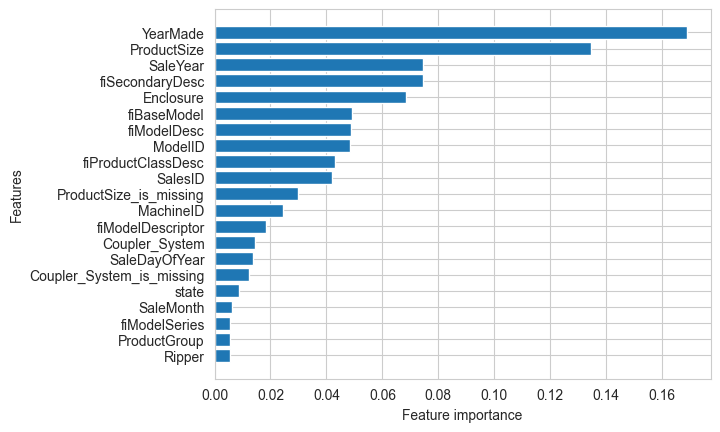

In [400]:
plot_feature_importances(columns=X_train.columns,
                         importances=best_rs_rf_reg.feature_importances_)

In [415]:

def plot_feature_importances(columns, importances, n=20, title="Feature Importances"):
    from matplotlib.pyplot import get_cmap
    
    # Prepare the data
    f_df = (
        pd.DataFrame({"features": columns, "feature_importances": importances})
        .sort_values("feature_importances", ascending=False)
        .reset_index(drop=True)
    )

    # Generate colors from the selected palette
    palette = "viridis"
    cmap = get_cmap(palette)
    colors = [cmap(i / n) for i in range(n)]  # Normalize colors to fit palette range

    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better visibility
    top_n = f_df.loc[:n-1]
    bars = ax.barh(top_n["features"], top_n["feature_importances"], color=colors, edgecolor="black")

    # Add values at the end of bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
                f"{width:.3f}", va="center", fontsize=10)

    # Add horizontal grid lines
    ax.xaxis.grid(True, linestyle="--", alpha=0.7)

    # Set labels, title, and invert y-axis for descending order
    ax.set_xlabel("Feature Importance", fontsize=14)
    ax.set_ylabel("Features", fontsize=14)
    ax.set_title(title, fontsize=16, weight="bold")
    ax.invert_yaxis()

    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout()
    plt.show()




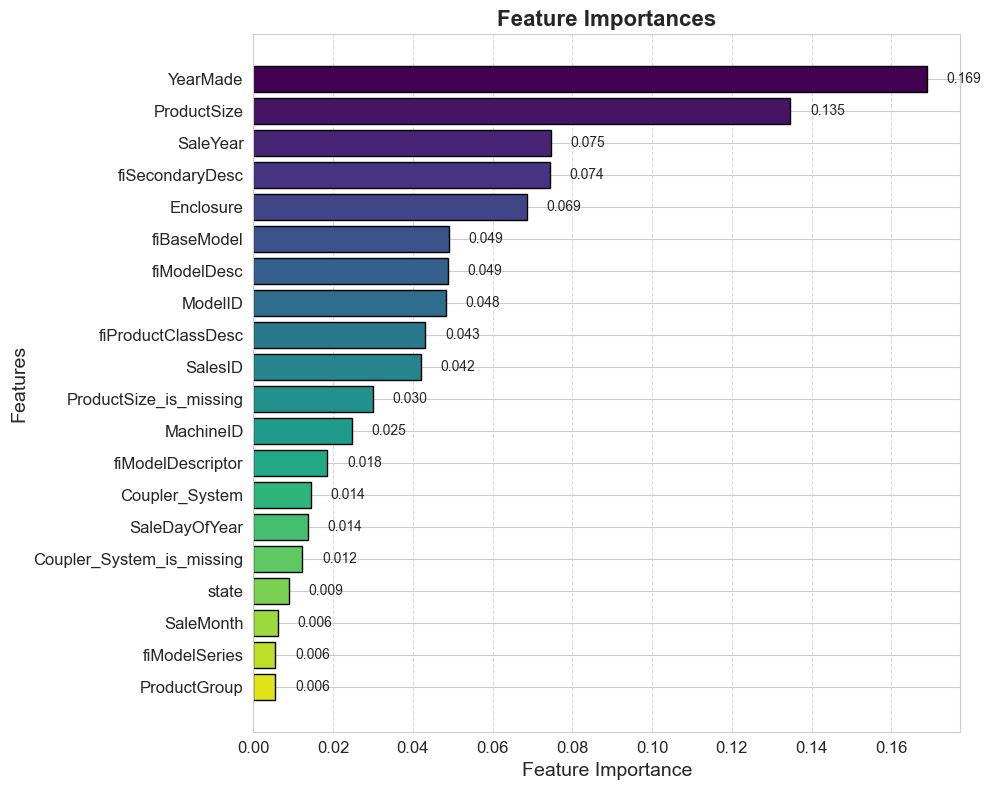

In [416]:
plot_feature_importances(columns=X_train.columns,
                         importances=best_rs_rf_reg.feature_importances_)